# Toy Examples on my own NFs

1d and 2D AffineElementwise and Positive-Linear Flows (without conditioner net)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import torch
import torch.distributions as D

sys.path.append('../flows/')
from mytransforms import AffineElementwiseTransform, PositiveLinearTransform
from myflow import Flow
from eval import plot_pdfs_1D, plot_2d_pdf_contours

%matplotlib inline

## 1D Normal Base Distribution & Affine Transformation

### Target distribution & Synthetic data

In [3]:
# Define 1D target distributions
# We do not usually know them... but we have access to samples!
# We will try to approximate them using the samples!

# Gaussian distribution
mean = 5.
std = 0.2
normal_dist = D.Normal(mean, std) 

# Gaussian Mixture Model with 2 equally weighted gaussian distributions
mix = D.Categorical(torch.ones(2,))
comp = D.Normal(torch.randn(2,)+torch.ones(2,)*10, torch.rand(2,))
gmm_dist = D.MixtureSameFamily(mix, comp)

# Exponential distribution
rate = 1
exp_dist = D.Exponential(rate)

target_dists = {'gaussian': normal_dist, 'gmm': gmm_dist, 'exp': exp_dist}

In [4]:
# Generate training data samples
target_dist = target_dists['gaussian'] # We do not usually know this...
x_samples = target_dist.sample((50,))  # ...but all we have are these samples.

### Flow and training

In [5]:
# Define base distribution 
base_dist = D.Normal(torch.tensor(0.0), torch.tensor(1.0))

# Define transformation
transform = AffineElementwiseTransform()

# Construct Flow
flow = Flow(base_dist, transform)

# Fit flow to the x_samples: learn the parameters of the transformation 
flow.train(x_samples, num_epochs=1000)


### Evaluate learned distribution

In [6]:
# Draw samples from the learned distribution 
x_samples_new = flow.sample(100)

# If the target distribution is Normal, we can check if mean and std were correctly learned 
print(torch.mean(x_samples_new))
print(torch.std(x_samples_new))

tensor(5.0386, grad_fn=<MeanBackward0>)
tensor(0.2142, grad_fn=<StdBackward0>)


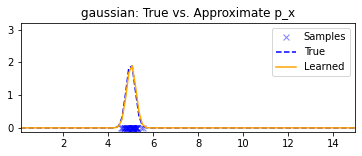

In [7]:
# Evaluate the learnt transformation by plotting the learnt p_x against the true distribution and the training samples
plot_pdfs_1D(target_dists['gaussian'], x_samples, flow, title = 'gaussian: True vs. Approximate p_x')


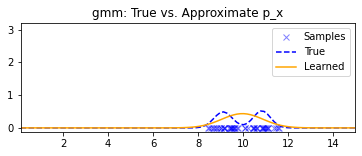

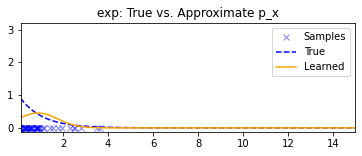

In [45]:
# Plot for gmm eand exp distributions
for dist in ['gmm','exp']:
    target_dist = target_dists[dist] 
    x_samples = target_dist.sample((50,))  

    base_dist = D.Normal(torch.tensor(0.0), torch.tensor(1.0))
    transform = AffineElementwiseTransform()
    flow = Flow(base_dist, transform)
    flow.train(x_samples, num_epochs=500)

    plot_pdfs_1D(target_dist, x_samples, flow, title = dist+': True vs. Approximate p_x')

## 2D Multivariate Normal Base Distribution

### Target distributions for synthetic data

In [46]:
# Define 2D target distributions
# We do not usually know them... but we have access to samples!
# We will try to approximate them using the samples!

n = 300 # Number of datapoints
d = 2 # Dimension of the multivariate distribution

# Multivariate Gaussian distribution
means = torch.FloatTensor([2, 9])
# cov_matrix = torch.eye(d)*0.2 + torch.rand((d,d))
cov_matrix = torch.FloatTensor([[0.5, 0.5],[0.3, 0.3]])
multi_normal_dist = D.multivariate_normal.MultivariateNormal(means, cov_matrix) 

# Blobs:2D Gaussian Mixture Model with 3 equally weighted gaussian distributions
mix = D.Categorical(torch.ones(3,))
# gmm_means= torch.randn(3,d)*5
gmm_means = torch.FloatTensor([[-3., -3.], [ 2.,  2.], [ 7., -6.]])
# gmm_stds = torch.rand(3,d)
# gmm_stds = torch.FloatTensor([[0.5, 0.5],[0.3, 0.3]])
gmm_stds = torch.eye(d) 
#comp = D.Independent(D.Normal(gmm_means, gmm_stds), 1)  # only diagonal covariance matrices...
comp = D.multivariate_normal.MultivariateNormal(gmm_means, gmm_stds)
gmm_dist_2D = D.mixture_same_family.MixtureSameFamily(mix, comp)

target_dists_2D = {'gaussian': multi_normal_dist, 'blobs': gmm_dist_2D}


### Base distribution and transformations

In [47]:
# Define base distribution 
base_dist = D.MultivariateNormal(torch.zeros(d), torch.eye(d))
# Define transformations 
transformations = {'affineEwise': AffineElementwiseTransform(z_dim=d), 'poslinear': PositiveLinearTransform(z_dim=d)}

### Multivariate Gaussian Target

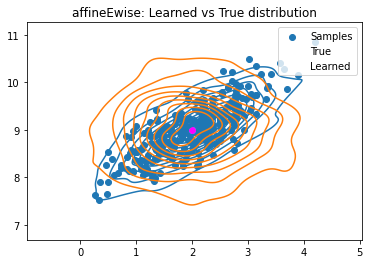

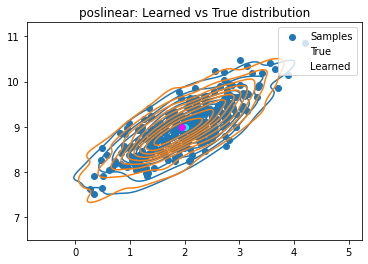

In [48]:
# Generate training data samples
target_dist = target_dists_2D['gaussian'] # We do not usually know this...
x_samples = target_dist.sample((n,))  # ...but all we have are these samples.

for trans in list(transformations.keys()):
    # Construct Flow
    flow = Flow(base_dist, transformations[trans])
    # Train Flow 
    flow.train(x_samples, num_epochs=500, lr=0.02)
    #Evaluate learned pdf
    plot_2d_pdf_contours(target_dist, x_samples, flow, title=trans+': Learned vs True distribution', gaussian=True)

### Blobs/GMM Target

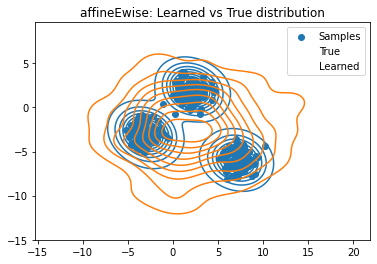

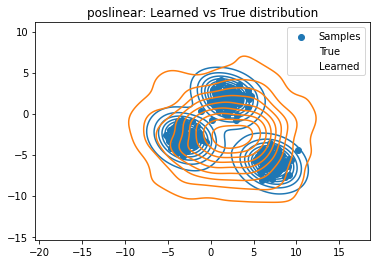

In [49]:
# Generate training data samples
target_dist = target_dists_2D['blobs'] # We do not usually know this...
x_samples = target_dist.sample((n,))  # ...but all we have are these samples.

for trans in list(transformations.keys()):
    # Construct Flow
    flow = Flow(base_dist, transformations[trans])
    # Train Flow 
    flow.train(x_samples, num_epochs=1000, lr=0.02)
    #Evaluate learned pdf
    plot_2d_pdf_contours(target_dist, x_samples, flow, title=trans+': Learned vs True distribution')

Same as in the 1D example, the gmm approximation fails because a linear transformation of a normal distribution (even multivariate), stays guassian. 

TODO: 
- spline transformation
- coupling layers 
- Planar Flow
- MAF - will not solve the mixture problem in 1D, but allowes for non-linear dependencies between covariates in 2D 
- NSF - will normally solve the mixture problem in both cases 
- stacking different transforms 

## Multimodal base-distribution

### 1D 

In [50]:
# Data Dimension
n = 500 # Number of datapoints
d = 1 # Dimension of the multivariate distribution

# Target distributions: 
# Gaussian Mixture Model with 2 equally weighted gaussian distributions
mix = D.Categorical(torch.ones(2,))
means = torch.FloatTensor([8,10])
stds = torch.FloatTensor([0.3,0.9])
comp = D.Normal(means, stds)
gmm_target = D.MixtureSameFamily(mix, comp)

# Generate training data samples
x_samples = gmm_target.sample((n,))  

# Define base distribution 
mix_bs = D.Categorical(torch.ones(2,))
comp_bs = D.Normal(torch.zeros(2,), torch.ones(2,))
gmm_base_dist = D.MixtureSameFamily(mix_bs, comp_bs)

# Define transformation
transform = AffineElementwiseTransform()

# Construct Flow
flow = Flow(gmm_base_dist, transform)

# Fit flow to the x_samples: learn the parameters of the transformation 
flow.train(x_samples, num_epochs=2000)


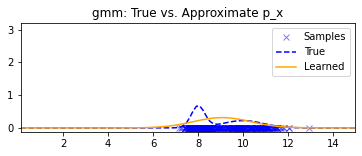

In [51]:
plot_pdfs_1D(gmm_target, x_samples, flow, title = 'gmm: True vs. Approximate p_x')


### 2D

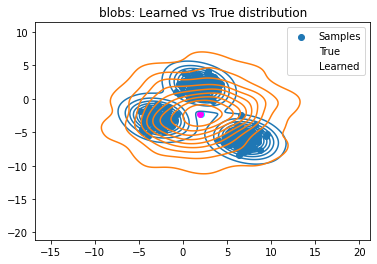

In [52]:
# Data Dimension
n = 300 # Number of datapoints
d = 2 # Dimension of the multivariate distribution

# Target distribution
# Blobs: 2D Gaussian Mixture Model with 3 equally weighted gaussian distributions
mix = D.Categorical(torch.ones(3,))
gmm_means = torch.FloatTensor([[-3., -3.], [ 2.,  2.], [ 7., -6.]])
gmm_stds = torch.eye(d) 
comp = D.multivariate_normal.MultivariateNormal(gmm_means, gmm_stds)
gmm_target_2D = D.mixture_same_family.MixtureSameFamily(mix, comp)

# Define base distribution 
mix_bs = D.Categorical(torch.ones(3,))
gmm_means= torch.zeros(3,d)
gmm_stds = torch.eye(d) 
comp_bs = D.multivariate_normal.MultivariateNormal(gmm_means, gmm_stds)
gmm_base_dist_2D = D.mixture_same_family.MixtureSameFamily(mix_bs, comp_bs)

x_samples = gmm_target_2D.sample((n,))  # ...but all we have are these samples.

# Construct Flow
transformation = PositiveLinearTransform(z_dim=d)
flow = Flow(gmm_base_dist_2D, transformation)
# Train Flow 
flow.train(x_samples, num_epochs=1000, lr=0.02)
#Evaluate learned pdf
plot_2d_pdf_contours(gmm_target_2D, x_samples, flow, title='blobs: Learned vs True distribution', gaussian=True)


Not working as hoped.. This is because two or more independant gaussian distributions cannot be estimated via the same affine transformation: we would need either an affine transformation per mode (different scale and shift per mode), or to stack different affine transformations on permutated coordinates (enable non-linear combinations and thus different scale and shifts to capute different modes).

Influence of:
- permutations between MADEs: without cannot decouple modes - result are connected non equally weighted blobs. They enable to combine different affine transformations on different coordinates which in turn enables to capture the modes.
- number of layers : one not enough to capture the 3 modes of the true target (gets stuck), the more layers, the better the blobs-approximation and the less iterations needed 

TODO: 
look at 1D 